# Imports

In [146]:
import pandas as pd 
import numpy  as np

import matplotlib.pyplot as plt
import seaborn           as sns 

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import classification_report, accuracy_score
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Loading Data

In [147]:
cancer_df = pd.read_csv('wbc.csv')
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [148]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [149]:
cancer_df.drop('Unnamed: 32', axis=1,inplace=True)
cancer_df.shape

(569, 32)

# Data Preparation

In [150]:
X = cancer_df.drop(['id','diagnosis'], axis=1).copy()
y = cancer_df['diagnosis'].copy()

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state=42)

# Training Model

In [151]:
#                                               CARTS MODELS
# Instantiate Logistic Regression, KNeighbors Classifier, DecisionTreeClassifier
lr = LogisticRegression(random_state=42,max_iter=7600)
param_lr = {'C': np.logspace(-5, 8, 15)} 
knn = KNeighborsClassifier()
param_knn = {'n_neighbors':[*range(20,41)]}
dt = DecisionTreeClassifier(random_state=42)
param_dt = {'max_depth': [*range(2,10)], 'min_samples_leaf':[0.1, 0.15],'max_features': [0.2,0.4,0.6]}

# list of classifiers
classifiers = [('Logistic Regression', lr, param_lr), ('K Nearest Neighbours', knn, param_knn), ('Decision Tree', dt, param_dt)]

# Evaluate Classifiers 
for clf_name, clf, param in classifiers:   
    grid_clf = GridSearchCV(clf, param, cv=5)
    grid_clf.fit(X_train, y_train)    
    y_pred = grid_clf.predict(X_test)
    accuracy = grid_clf.score(X_test,y_test)   
    print(clf_name, ':', round(accuracy,3))
    print(pd.crosstab(y_test, y_pred))
    print(grid_clf.best_params_)
    print()

Logistic Regression : 0.989
col_0        B   M
diagnosis         
B          120   1
M            1  66
{'C': 0.4393970560760795}

K Nearest Neighbours : 0.952
col_0        B   M
diagnosis         
B          120   1
M            8  59
{'n_neighbors': 23}

Decision Tree : 0.931
col_0        B   M
diagnosis         
B          117   4
M            9  58
{'max_depth': 3, 'max_features': 0.2, 'min_samples_leaf': 0.1}



In [155]:
# Set the models to their best parameters
lr = LogisticRegression(C= 0.4393970560760795, random_state=42,max_iter=7600)
knn = KNeighborsClassifier(n_neighbors=23)
dt = DecisionTreeClassifier(max_depth=3, max_features=0.2, min_samples_leaf= 0.1, random_state=42)

# list of classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Decision Tree', dt)]

In [159]:
#                                               ENSEBLE MODELS
# Voting Classifier
vc = VotingClassifier(estimators=classifiers)     
vc.fit(X_train, y_train)   
y_pred = vc.predict(X_test)
accuracy = vc.score(X_test,y_test)
print('All Models Voting Classifier: ', round(accuracy, 3))
print(pd.crosstab(y_test, y_pred))
print()

# Random Forest
rf = RandomForestClassifier(n_estimators=25, random_state=42)  
params = {'max_depth': [*range(3,15, 2)],'n_estimators':[100,350,500], 'max_features':[ 'log2', 'auto', 'sqrt'], 'min_samples_leaf':[ 8, 15, 20]}
grid_rf = GridSearchCV(rf, params,cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train) 
y_pred = grid_rf.predict(X_test)
accuracy = grid_rf.score(X_test,y_test)
print('Random Forest Test set accuracy:', round(accuracy, 3))
print(pd.crosstab(y_test, y_pred))
print(grid_rf.best_params_)
print()

# Bagging Classifier
for clf_name, clf in classifiers: 
    bgg = BaggingClassifier(base_estimator=clf, n_estimators=50, oob_score=True, random_state=1)
    bgg.fit(X_train, y_train)
    y_pred = bgg.predict(X_test)
    accuracy = bgg.score(X_test,y_test)
    acc_oob = bgg.oob_score_
    print(clf_name, 'Test set accuracy: ', round(accuracy,3), 'OOB accuracy: ', round(acc_oob, 3))
    print(pd.crosstab(y_test, y_pred))
    print()

All Models Voting Classifier:  0.968
col_0        B   M
diagnosis         
B          119   2
M            4  63

Random Forest Test set accuracy: 0.957
col_0        B   M
diagnosis         
B          117   4
M            4  63
{'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 100}

Logistic Regression Test set accuracy:  0.989 OOB accuracy:  0.979
col_0        B   M
diagnosis         
B          120   1
M            1  66

Random Forests Test set accuracy:  0.963 OOB accuracy:  0.953
col_0        B   M
diagnosis         
B          118   3
M            4  63

Decision Tree Test set accuracy:  0.952 OOB accuracy:  0.924
col_0        B   M
diagnosis         
B          117   4
M            5  62



In [160]:
# Random Forest with best parameters
rf = RandomForestClassifier(max_depth= 5,n_estimators= 100,max_features='log2', min_samples_leaf= 8, random_state=42) 

In [161]:
#                                          BOOSTING CLASSIFIERS
# AdaBoost Classifier
classifiers = [('Logistic Regression', lr), ('Random Forests', rf), ('Decision Tree', dt)]
for clf_name, clf in classifiers: 
    ada = AdaBoostClassifier(base_estimator=clf, n_estimators=180, random_state=1)
    ada.fit(X_train,y_train)
    y_pred = ada.predict(X_test)
    accuracy = ada.score(X_test,y_test)
    print(clf_name, 'AdaBoost Test set accuracy: ', round(accuracy,3))
    print(pd.crosstab(y_test, y_pred))
    print()
    
# Gradient Boosting Classifier
gb = GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=2)
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
accuracy = gb.score(X_test,y_test)
print('Gradient Boosting Test set accuracy:', round(accuracy, 3))
print(pd.crosstab(y_test, y_pred))
print()

Logistic Regression AdaBoost Test set accuracy:  0.984
col_0        B   M
diagnosis         
B          119   2
M            1  66

Random Forests AdaBoost Test set accuracy:  0.968
col_0        B   M
diagnosis         
B          118   3
M            3  64

Decision Tree AdaBoost Test set accuracy:  0.957
col_0        B   M
diagnosis         
B          118   3
M            5  62

Gradient Boosting Test set accuracy: 0.957
col_0        B   M
diagnosis         
B          118   3
M            5  62



# Performance Metrics

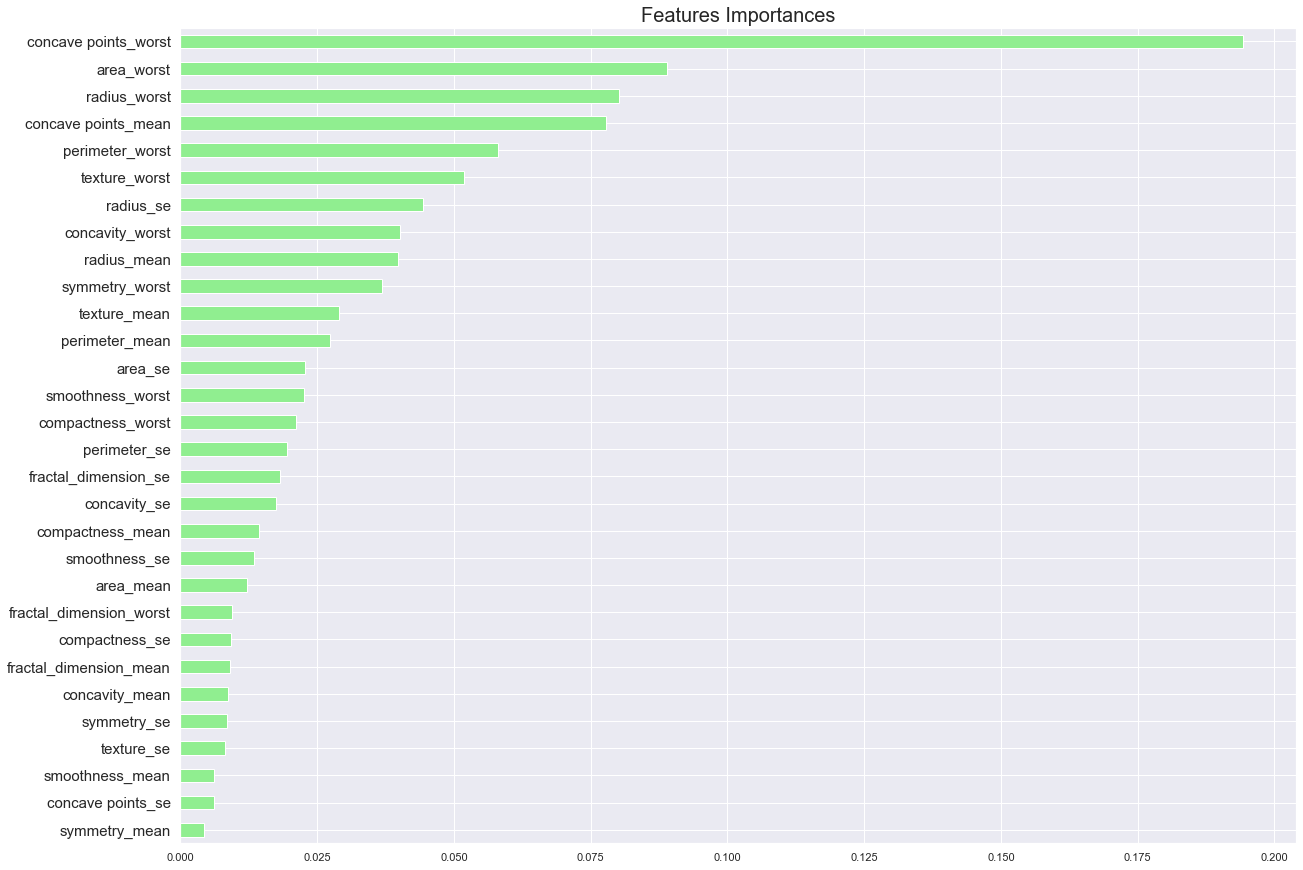

In [169]:
# Create a pd.Series of features importances
ada = AdaBoostClassifier(base_estimator=rd, n_estimators=180, random_state=1)
ada.fit(X_train,y_train)
importances = pd.Series(data=ada.feature_importances_, index= cancer_df.drop(['id','diagnosis'], axis=1).copy().columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances', fontsize=20)
plt.yticks(fontsize=15)
plt.show()